# Cass-Koopmans Planning Problem and Cass-Koopmans Competitive Equilibrium
## Agenda

- optimal growth分析としてのCass-Koopmans Planning Problem Frameworkの紹介
- planned economyとcompetitive equilibriumの関係性を学ぶ
- competitive equilibrium modelを用いたsimulation方法を学ぶ
- Hicks-Arrow prices

### keywords

- A min-max problem for solving the planning problem.
- A shooting algorithm for solving difference equations subject to initial and terminal conditions.

### 参考

- [QuantEcon Cass-Koopmans Planning Problem](https://python.quantecon.org/cass_koopmans_1.html)
- [Cass-Koopmans Competitive Equilibrium](https://python.quantecon.org/cass_koopmans_2.html)


### Python

In [1]:
!python -V

Python 3.7.4


### Import

In [2]:
from numba import njit,float64
from numba.experimental import jitclass
import numpy as np
import matplotlib.pyplot as plt

## 1. Cass-Koopmans Planning Problem 

### Modelの設定

- t: discrete time index, $t = 0, 1, ..., T$
- goodsは１種類とする、$C_t, I_t$, (consumption/investment)のいずれかに振り分けることができる
- $C_t$: comsumption level at time t, comsumptionはnon-durableとする, i.e., consumptionはすぐcompletely depreciateする
- $K_t$:stock of physical capital at time t, capital goodsはdurableで毎期ちょっとずつdepreciateする
- $K_0>0$で外生的に付与される
- A representative householdはone unit of labor, $N_t$を毎期付与される
- A representative householdはinelasticallyにlaborを毎期供給する
- $\vec{C} = \{C_0, ..., C_T\}$
- $\vec{K} = \{K_0, ..., K_{T+1}\}$

The representative householdのpreferenceは以下のように表現される：

$$
U(\vec{C}) = \sum_{t=0}^{T} \beta^t \frac{C_t^{1-\gamma}}{1-\gamma} = \sum_{t=0}^{T} \beta^t u(C_t) \tag{1}
$$

- $\beta \in (0, 1)$
- $\gamma > 0$

an economy-wide production functionは

$$
F(K_t,N_t) = A K_t^{\alpha}N_t^{1-\alpha} \tag{2}
$$

- $A > 0$
- $\alpha \in (0, 1)$

成約式は

$$
C_t + K_{t+1} \leq F(K_t,N_t) + (1-\delta) K_t, \quad \text{for all } t \in [0, T] \tag{3}
$$

- $\delta \in (0, 1)$はthe depreciation rate


### Planning Problem

- A planner chooses an allocation $\{\vec{C}, \vec K\}$ to maximize (1) subject to (3)
- $\vec{\mu}=\{\mu_0,\dots,\mu_T\}$: nonnegative Lagrange multipliers

問題を定式化すると

$$
\mathcal{L}(\vec{C} ,\vec{K} ,\vec{\mu} ) =
\sum_{t=0}^T \beta^t\left\{ u(C_t)+ \mu_t
\left(F(K_t,1) + (1-\delta) K_t- C_t - K_{t+1} \right)\right\}
$$

- $N_t = 1$を用いている

then,

$$
\min_{\vec{\mu}} \max_{\vec{C},\vec{K}} \mathcal{L}(\vec{C},\vec{K},\vec{\mu} ) \tag{4}
$$

なお、

$$
\frac{F(K_t,N_t)}{N_t} \equiv f\left(\frac{K_t}{N_t}\right) = A\left(\frac{K_t}{N_t}\right)^\alpha \tag{5}
$$
と定義しておく。


### FOCs

$$
C_t: \qquad u'(C_t)-\mu_t=0 \qquad \text{for all} \quad t= 0,1,\dots,T \tag{6}
$$

$$
K_t: \qquad \beta \mu_t\left[(1-\delta)+f'(K_t)\right] - \mu_{t-1}=0 \qquad \text{for all } \quad t=1,2,\dots,T \tag{7}
$$

$$
\mu_t:\qquad F(K_t,1)+ (1-\delta) K_t  - C_t - K_{t+1}=0 \qquad \text{for all } \quad t=0,1,\dots,T \tag{8}
$$

$$
K_{T+1}: \qquad -\mu_T \leq 0, \ \leq 0 \text{ if } K_{T+1}=0; \ =0 \text{ if } K_{T+1}>0 \tag{9}
$$

(9)はKKT conditionより導出：

$$
\mu_T K_{T+1}=0 \tag{10}
$$

なお、$T\to \infty$の場合は、

$$
\lim_{T \rightarrow +\infty} \beta^T u'(C_T) K_{T+1} = 0 ,
$$

ここで(6), (7)より

$$
u'(C_t) = \mu_t
$$

を用いて、

$$
u'\left(C_t\right)\left[(1-\delta)+f'\left(K_t\right)\right]-u'\left(C_{t-1}\right)=0
\quad \text{ for all } t=1,2,\dots, T+1
$$

これより

$$
u'\left(C_{t+1}\right)\left[(1-\delta)+f'\left(K_{t+1}\right)\right]=
u'\left(C_{t}\right) \quad \text{ for all } t=0,1,\dots, T \tag{11}
$$

marginal utility functionのinverse functionを$u'^{-1}$とすると、

$$
C_{t+1} =u'^{-1}\left(\left(\frac{\beta}{u'(C_t)}[f'(K_{t+1}) +(1-\delta)]\right)^{-1}\right)
$$

従って以下を得る：

$$
\begin{aligned} C_{t+1} =\left(\beta C_t^{\gamma}[f'(K_{t+1}) +
(1-\delta)]\right)^{1/\gamma} \notag\\= C_t\left(\beta [f'(K_{t+1}) +
(1-\delta)]\right)^{1/\gamma} \end{aligned}
$$

### Computationの準備

まずhyper-parameterのリストを定義する

In [3]:
planning_data = [
    ('γ', float64),    # Coefficient of relative risk aversion
    ('β', float64),    # Discount factor
    ('δ', float64),    # Depreciation rate on capital
    ('α', float64),    # Return to capital per capita
    ('A', float64)     # Technology
]

In [4]:
@jitclass(planning_data)
class PlanningProblem():

    def __init__(self, γ=2, β=0.95, δ=0.02, α=0.33, A=1):
        # define exogeneous variables
        self.γ, self.β = γ, β
        self.δ, self.α, self.A = δ, α, A

    def u(self, c):
        '''
        Utility function
        ASIDE: If you have a utility function that is hard to solve by hand
        you can use automatic or symbolic differentiation
        See https://github.com/HIPS/autograd
        '''
        γ = self.γ

        return c ** (1 - γ) / (1 - γ) if γ!= 1 else np.log(c)

    def u_prime(self, c):
        'Derivative of utility, Marginal Utility'
        γ = self.γ

        return c ** (-γ)

    def u_prime_inv(self, c):
        'Inverse of derivative of utility'
        γ = self.γ

        return c ** (-1 / γ)

    def f(self, k):
        'Production function'
        α, A = self.α, self.A

        return A * k ** α

    def f_prime(self, k):
        'Derivative of production function'
        α, A = self.α, self.A

        return α * A * k ** (α - 1)

    def f_prime_inv(self, k):
        'Inverse of derivative of production function'
        α, A = self.α, self.A

        return (k / (A * α)) ** (1 / (α - 1))

    def next_k_c(self, k, c):
        ''''
        Given the current capital Kt and an arbitrary feasible
        consumption choice Ct, computes Kt+1 by state transition law
        and optimal Ct+1 by Euler equation.
        '''
        β, δ = self.β, self.δ
        u_prime, u_prime_inv = self.u_prime, self.u_prime_inv
        f, f_prime = self.f, self.f_prime

        k_next = f(k) + (1 - δ) * k - c # law of motion
        c_next = u_prime_inv(u_prime(c) / (β * (f_prime(k_next) + (1 - δ)))) # Euler equation

        return k_next, c_next

construct objectを作る

In [5]:
pp = PlanningProblem()

### Shooting Algorithm

FOCs (6), (7), (8)は conditions付きのa system of difference equationsをなしている。conditionsはinitial conditionとterminal conditionの二つ：

- $K_0$: a given initial condition for capital
- $K_{T+1} = 0$: a terminal condition for capital

$\mu_0$が与えられているならばFOCsを用いることで計算できるが、今回はない。そこでShooting Algirithmを用いる。Shooting Algorithmはguess and verifyの一種。計算ステップは以下、

1. Guess an initial Lagrange multiplier $\mu_0$
2. Apply the simple algorithm described above.
3. Compute $k_{T+1}$ and check whether it equals zero.
4. If $k_{T+1} = 0$, we have solved the problem. If $k_{T+1} > 0$, lower $\mu_0$ and try again. If $k_{T+1} < 0$, raise $\mu_0$ and try again

以下でshooting algirithmを実装したものを紹介する（ここでは$C_0$をguess and verifyしている）

In [6]:
@njit
def shooting(pp, c0, k0, T=10):
    '''
    Given the initial condition of capital k0 and an initial guess
    of consumption c0, computes the whole paths of c and k
    using the state transition law and Euler equation for T periods.
    '''
    if c0 > pp.f(k0):
        print("initial consumption is not feasible")

        return None

    # initialize vectors of c and k
    c_vec = np.empty(T+1)
    k_vec = np.empty(T+2)

    c_vec[0] = c0
    k_vec[0] = k0

    for t in range(T):
        k_vec[t+1], c_vec[t+1] = pp.next_k_c(k_vec[t], c_vec[t])

    k_vec[T+1] = pp.f(k_vec[T]) + (1 - pp.δ) * k_vec[T] - c_vec[T]

    return c_vec, k_vec

In [7]:
paths = shooting(pp, 0.2, 0.3, T=10)

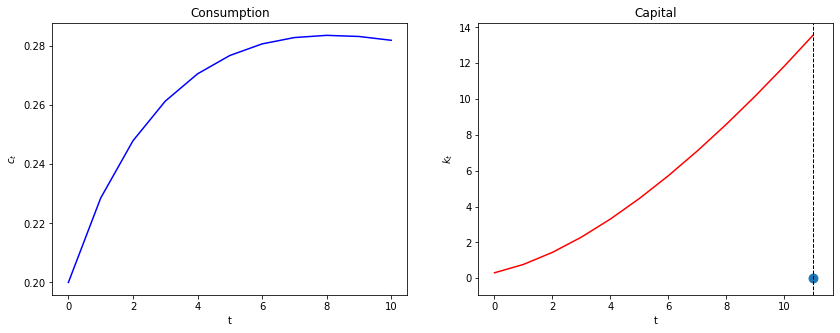

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

colors = ['blue', 'red']
titles = ['Consumption', 'Capital']
ylabels = ['$c_t$', '$k_t$']

T = paths[0].size - 1
for i in range(2):
    axs[i].plot(paths[i], c=colors[i])
    axs[i].set(xlabel='t', ylabel=ylabels[i], title=titles[i])

axs[1].scatter(T+1, 0, s=80)
axs[1].axvline(T+1, color='k', ls='--', lw=1)

initial guessがtoo highであることが読み取れる。ここでbisection methodを利用したプログラムを実装する。

In [9]:
@njit
def bisection(pp, c0, k0, T=10, tol=1e-4, max_iter=500, k_ter=0, verbose=True):

    # initial boundaries for guess c0
    c0_upper = pp.f(k0)
    c0_lower = 0 # modelのintuitionより設定した下限

    i = 0
    while True:
        c_vec, k_vec = shooting(pp, c0, k0, T)
        error = k_vec[-1] - k_ter

        # check if the terminal condition is satisfied
        if np.abs(error) < tol:
            if verbose:
                print('Converged successfully on iteration ', i+1)
            return c_vec, k_vec

        i += 1
        if i == max_iter:
            if verbose:
                print('Convergence failed.')
            return c_vec, k_vec

        # if iteration continues, updates boundaries and guess of c0
        if error > 0:
            c0_lower = c0
        else:
            c0_upper = c0

        c0 = (c0_lower + c0_upper) / 2

In [10]:
def plot_paths(pp, c0, k0, T_arr, k_ter=0, k_ss=None, axs=None):

    if axs is None:
        fix, axs = plt.subplots(1, 3, figsize=(16, 4))
    ylabels = ['$c_t$', '$k_t$', '$\mu_t$']
    titles = ['Consumption', 'Capital', 'Lagrange Multiplier']

    c_paths = []
    k_paths = []
    for T in T_arr:
        c_vec, k_vec = bisection(pp, c0, k0, T, k_ter=k_ter, verbose=False)
        c_paths.append(c_vec)
        k_paths.append(k_vec)

        μ_vec = pp.u_prime(c_vec)
        paths = [c_vec, k_vec, μ_vec]

        for i in range(3):
            axs[i].plot(paths[i])
            axs[i].set(xlabel='t', ylabel=ylabels[i], title=titles[i])

        # Plot steady state value of capital
        if k_ss is not None:
            axs[1].axhline(k_ss, c='k', ls='--', lw=1)

        axs[1].axvline(T+1, c='k', ls='--', lw=1)
        axs[1].scatter(T+1, paths[1][-1], s=80)

    return c_paths, k_paths

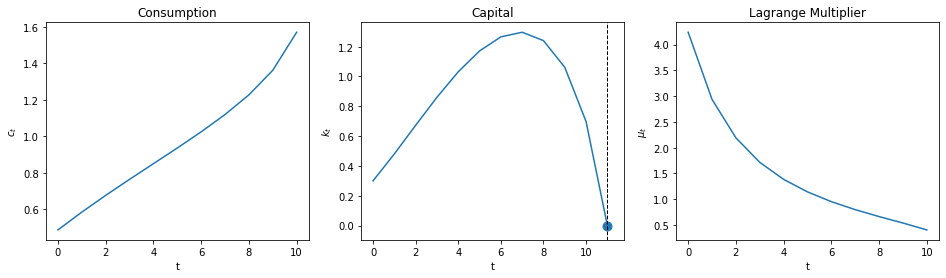

In [11]:
plot_paths(pp, 0.3, 0.3, [10]);

### Setting Initial Capital to Steady State Capital

$T \to \infty$の場合、the optimal allocationはsteady state valueに収束する。このとき、steady stateの定義より

$$
K_{t+1} = K_t=\bar{K} \qquad\text{for all very large } t
$$

また,
$$
f(\bar{K})-\delta \bar{K} = \bar{C} \tag{12}
$$

steady state valueをeuler equationsに代入すると、

$$
1=\beta \frac{u'(\bar{C})}{u'(\bar{C})}[f'(\bar{K})+(1-\delta)]
$$

を得る。$\beta = 1/(1 + \rho)$とすると
。
$$
1+\rho = 1[f'(\bar{K}) + (1-\delta)]
$$

を得る。これらを整理すると、

$$
f'(\bar{K}) = \rho +\delta
$$

and 

$$
f'(\bar{K}) = \rho +\delta
$$


In [12]:
ρ = 1 / pp.β - 1
k_ss = pp.f_prime_inv(ρ+pp.δ)

print(f'steady state for capital is: {k_ss}')

steady state for capital is: 9.57583816331462


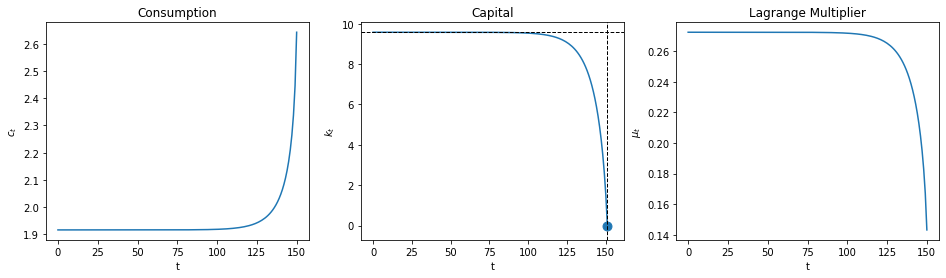

In [13]:
plot_paths(pp, 0.3, k_ss, [150], k_ss=k_ss);

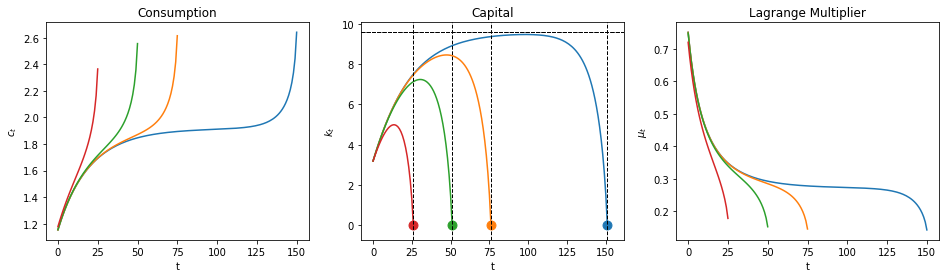

In [14]:
plot_paths(pp, 0.3, k_ss/3, [150, 75, 50, 25], k_ss=k_ss);

次にsaving rateの変化をplotする

In [15]:
@njit
def saving_rate(pp, c_path, k_path):
    'Given paths of c and k, computes the path of saving rate.'
    production = pp.f(k_path[:-1])

    return (production - c_path) / production

In [16]:
def plot_saving_rate(pp, c0, k0, T_arr, k_ter=0, k_ss=None, s_ss=None):

    fix, axs = plt.subplots(2, 2, figsize=(12, 9))

    c_paths, k_paths = plot_paths(pp, c0, k0, T_arr, k_ter=k_ter, k_ss=k_ss, axs=axs.flatten())

    for i, T in enumerate(T_arr):
        s_path = saving_rate(pp, c_paths[i], k_paths[i])
        axs[1, 1].plot(s_path)

    axs[1, 1].set(xlabel='t', ylabel='$s_t$', title='Saving rate')

    if s_ss is not None:
        axs[1, 1].hlines(s_ss, 0, np.max(T_arr), linestyle='--')

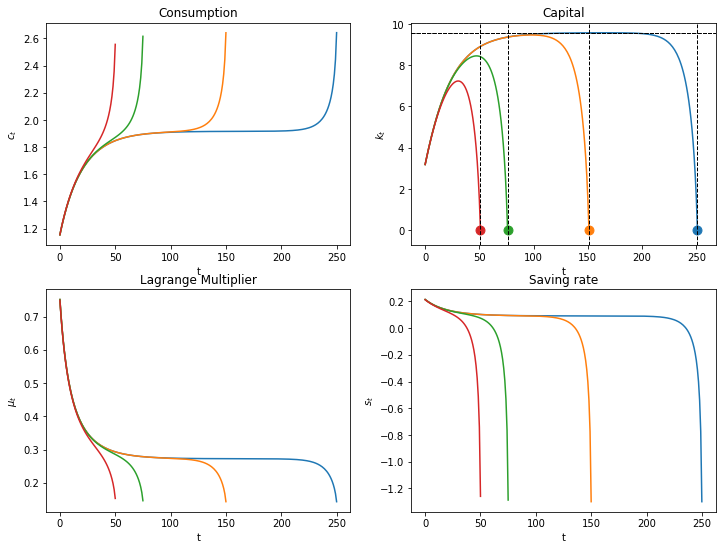

In [17]:
plot_saving_rate(pp, 0.3, k_ss/3, [250, 150, 75, 50], k_ss=k_ss)

## 2. Cass-Koopmans Competitive Equilibrium

planning problemとの違いは、今回考えるeconomyはdecentralized economyという点。

- social plannerが存在しない。
- A representative householdと a representative firmがそれぞれ独立に意思決定を行う

### 設定

- 毎期tにて、the householdはwageとrentals of capitalをfirmより受け取り、これらの合計がt期におけるincomeとなる
- householdは毎期incomeをconsumptionとsavingにそれぞれ割り当てる
- savingの具体的方法として(1) firmからcapitalを買う、(2) 未来のconsumptionのclaimを買うのいずれかがある
- firmは毎期、laborとcapitalを用いてgoodsを生産し、それをhouseholdに売る
- the householdとthe firmはそれぞれprice takerと仮定する

### Prices

$\{w_t,\eta_t\}_{t=0}^T= \{\vec{w}, \vec{\eta} \}$というsequences of pricesを考える。

- $w_t$: wage at time t
- $\eta_t$:  a rental rate for capital at time t

$q_t^0$をthe price of a good at date t relative to a good at date 0とする。$\{q^0_t\}_{t=0}^T$をa vector of Hicks-Arrow pricesと呼ぶ。

#### Relative priceのIntuition

$$
q^0_t=\frac{\text{number of time 0 goods}}{\text{number of time t goods}}
$$

### Firm Problem

t期にa representative firmはlabor, $\tilde n_t$, capital, $\tilde k_t$を用いて生産活動を行う。このときのthe firm's profitは

$$
q_t^0(F(\tilde k_t, \tilde n_t)-w_t \tilde n_t -\eta_t \tilde k_t)
$$

生産関数は

$$
F(\tilde k_t, \tilde n_t) = A \tilde k_t^\alpha \tilde n_t^{1-\alpha}
$$



#### Zero Profit Conditions

$$
F_k(\tilde k_t, \tilde n_t) =\eta_t \tag{13}
$$
and 

$$
F_n(\tilde k_t, \tilde n_t) =w_t \tag{14}
$$

これらの条件はa no-arbitrage requirementより導かれる。生産関数はhomegeneous degree of oneの関数なので

$$
\alpha F(\tilde k_t, \tilde n_t) =  F(\alpha  \tilde k_t, \alpha \tilde n_t)
$$

これを$\alpha$で微分すると、

$$
F(\tilde k_t,\tilde n_t) =_\text{chain rule} \frac{\partial F}{\partial \tilde k_t}
\tilde k_t + \frac{\partial F}{\partial \tilde  n_t} \tilde n_t
$$

次に、the firm's profitを書き直すと

$$
\left(\frac{\partial F}{\partial \tilde k_t}-\eta_t\right) \tilde k_t +
\left(\frac{\partial F}{\partial \tilde  n_t}-w_t\right) \tilde n_t
$$

を得る。

- $\frac{\partial F}{\partial \tilde k_t}> \eta_t$の場合、$\tilde k_t$はarbitrarily largeになる
- $\frac{\partial F}{\partial \tilde n_t}> \eta_t$の場合、$\tilde n_t$はarbitrarily largeになる



### Household Problem

t期におけるthe representative householdのincomeは

$$
w_t 1+ \eta_t k_t
$$

t期におけるincome allocationは

$$
\left(c_t + (k_{t+1} -(1-\delta)k_t)\right)
$$

なお借入も可能であるとする。A household’s net excess demand for time tを以下のように定義する：
$$
e_t \equiv \left(c_t + (k_{t+1} -(1-\delta)k_t)\right)-(w_t 1 + \eta_t k_t)
$$




#### The Budget constraint

$$
\sum_{t=0}^T q^0_t e_t  \leq 0
$$

よって、the household's constrained optimization problemは以下のようにかける

$$
\begin{aligned}& \max_{\vec{c}, \vec{k} }  \sum_{t=0}^T \beta^t u(c_t) \\ \text{subject to} \ \   & \sum_{t=0}^T q_t^0\left(c_t +\left(k_{t+1}-(1-\delta) k_t\right) -w_t -\eta_t k_t\right) \leq 0  \notag \end{aligned}
$$

### Computing a Competitive Equilibrium

計算方針はguess and verify

1. equilibrium price sequencesをguessする
2. guessされたprice sequencesの下、the householdとthe firmが同じallocationを選択するかverifyする

#### Guess for Price System

Social planning problemのallocationをThe Big Kと呼ぶ。このBig Kをinitial guessとする。

For $t=0,…,T$:

$$
\lambda q_t^0 = \beta^t u'(K_t) =\beta^t \mu_t \tag{15}
$$

$$
w_t = f(K_t) -K_t f'(K_t) \tag{16}
$$

$$
\eta_t = f'(K_t) \tag{17}
$$

The householdによって選択されるcapital levelを

$$
k^h_t(\vec {q}, \vec{w}, \vec{\eta)} , \quad t \geq 0 \tag{18}
$$

the firmによって選択されるcapital levelを

$$
k^f_t(\vec {q}, \vec{w}, \vec{\eta)} , \quad t \geq 0 \tag{19}
$$

とする。均衡条件は

$$
k_t^h  = k_t^f \tag{20}
$$

$$
1 = n_f^h = n_t^f \tag{21}
$$

$$
c_t^h + k_{t+1}^h - (1-\delta) k_t^h  = F(k_t^f, n_t^f)\tag{22}
$$


### Verification Procedure and Household’s Lagrangian

$$
\mathcal{L}(\vec{c},\vec{k},\lambda) = \sum_{t=0}^T \beta^t u(c_t)+ \lambda \left(\sum_{t=0}^T q_t^0\left(\left((1-\delta) k_t -w_t\right)
+\eta_t k_t -c_t  - k_{t+1}\right)\right)
$$

and

$$
\min_{\lambda} \max_{\vec{c},\vec{k}}  \mathcal{L}(\vec{c},\vec{k},\lambda)
$$

FOCs are

$$
c_t: \quad \beta^t u'(c_t)-\lambda q_t^0=0 \quad  t=0,1,\dots,T \tag{23}
$$

$$
k_t: \quad -\lambda q_t^0 \left[(1-\delta)+\eta_t \right]+\lambda q^0_{t-1}=0 \quad  t=1,2,\dots,T+1 \tag{24}
$$

$$
\lambda:  \quad \left(\sum_{t=0}^T q_t^0\left(c_t + \left(k_{t+1}-(1-\delta) k_t\right) -w_t -\eta_t k_t\right)\right) \leq 0 \tag{25}
$$

$$
k_{T+1}: \quad -\lambda q_0^{T+1} \leq 0, \ \leq 0 \text{ if } k_{T+1}=0; \ =0 \text{ if } k_{T+1}>0 \tag{26}
$$

このとき、$\lambda q_t = \mu_t$と置き換えると、social plannerの問題と同様の表現になる。よってcomputationは Cass-Koopmans Planning Modelと同様のものを用いることができる。

In [18]:
pp = PlanningProblem()

# Steady states
ρ = 1 / pp.β - 1
k_ss = pp.f_prime_inv(ρ+pp.δ)
c_ss = pp.f(k_ss) - pp.δ * k_ss

In [19]:
@njit
def q(pp, c_path):
    # Here we choose numeraire to be u'(c_0) -- this is q^(t_0)_t
    T = len(c_path) - 1
    q_path = np.ones(T+1)
    q_path[0] = 1 ## t = 0のpriceをnumeraireとする
    for t in range(1, T+1):
        q_path[t] = pp.β ** t * pp.u_prime(c_path[t])
    return q_path

@njit
def w(pp, k_path):
    w_path = pp.f(k_path) - k_path * pp.f_prime(k_path)
    return w_path

@njit
def η(pp, k_path):
    η_path = pp.f_prime(k_path)
    return η_path

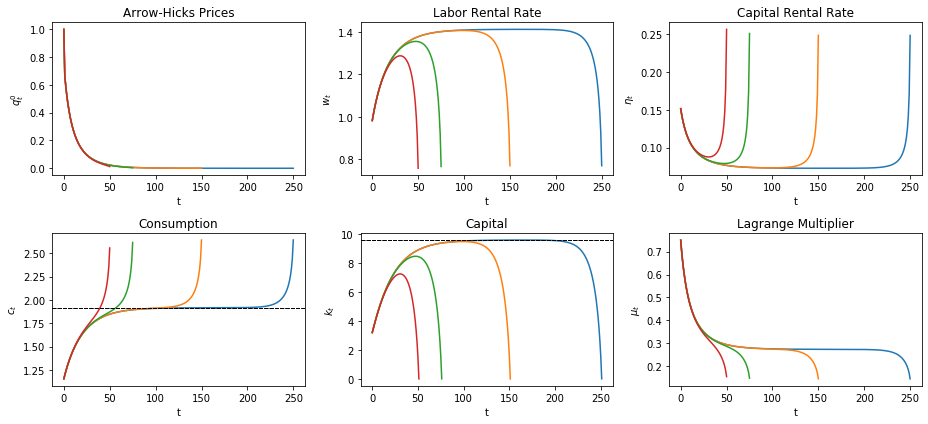

In [20]:
T_arr = [250, 150, 75, 50]

fix, axs = plt.subplots(2, 3, figsize=(13, 6))
titles = ['Arrow-Hicks Prices', 'Labor Rental Rate', 'Capital Rental Rate',
          'Consumption', 'Capital', 'Lagrange Multiplier']
ylabels = ['$q_t^0$', '$w_t$', '$\eta_t$', '$c_t$', '$k_t$', '$\mu_t$']

for T in T_arr:
    c_path, k_path = bisection(pp, 0.3, k_ss/3, T, verbose=False)
    μ_path = pp.u_prime(c_path)

    q_path = q(pp, c_path)
    w_path = w(pp, k_path)[:-1]
    η_path = η(pp, k_path)[:-1]
    paths = [q_path, w_path, η_path, c_path, k_path, μ_path]

    for i, ax in enumerate(axs.flatten()):
        ax.plot(paths[i])
        ax.set(title=titles[i], ylabel=ylabels[i], xlabel='t')
        if titles[i] is 'Capital':
            ax.axhline(k_ss, lw=1, ls='--', c='k')
        if titles[i] is 'Consumption':
            ax.axhline(c_ss, lw=1, ls='--', c='k')

plt.tight_layout()

### Varying Curvature

$\gamma$を様々な水準に設定し、curvatureがどのように異なるか検証する。$\gamma$はindividualのsmooth consumptionの程度を表しており、値が高いほど、steady stateまでの調整の速度が速くなる。

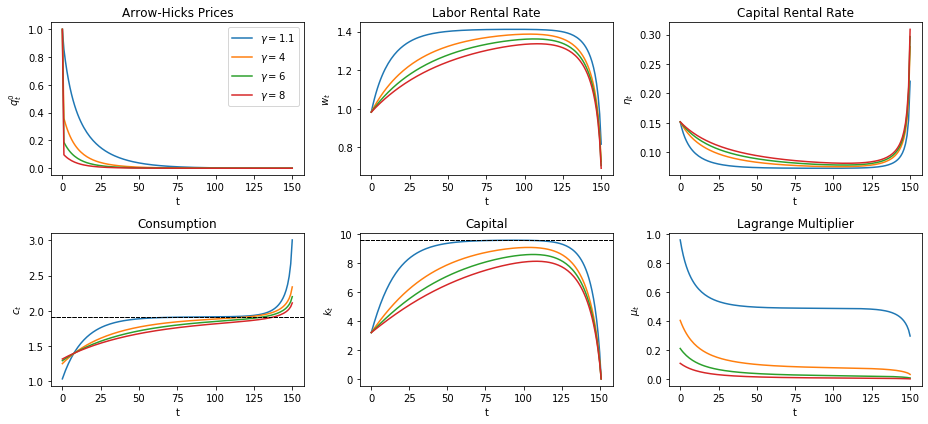

In [21]:
T = 150
γ_arr = [1.1, 4, 6, 8]

fix, axs = plt.subplots(2, 3, figsize=(13, 6))

for γ in γ_arr:
    pp_γ = PlanningProblem(γ=γ)
    c_path, k_path = bisection(pp_γ, 0.3, k_ss/3, T, verbose=False)
    μ_path = pp_γ.u_prime(c_path)

    q_path = q(pp_γ, c_path)
    w_path = w(pp_γ, k_path)[:-1]
    η_path = η(pp_γ, k_path)[:-1]
    paths = [q_path, w_path, η_path, c_path, k_path, μ_path]

    for i, ax in enumerate(axs.flatten()):
        ax.plot(paths[i], label=f'$\gamma = {γ}$')
        ax.set(title=titles[i], ylabel=ylabels[i], xlabel='t')
        if titles[i] is 'Capital':
            ax.axhline(k_ss, lw=1, ls='--', c='k')
        if titles[i] is 'Consumption':
            ax.axhline(c_ss, lw=1, ls='--', c='k')

axs[0, 0].legend()
plt.tight_layout()
plt.show()

### Yield Curves and Hicks-Arrow Prices

ここではHicks-Arrow pricesと yields on loans of alternative maturitiesがどのように関係しているのかを調べる。

t期に償還期限を迎えるA yield to maturity on a loan made at time $t_0$(in terms of log scale)は

$$
r_{t_0,t}= -\frac{\log q^{t_0}_t}{t - t_0}\tag{27}
$$



(27)は

$$
r_{t_0, t} = \log\left(\frac{q_t}{q_0}\right)^{-1/(t-t_0)} = \log\left(\frac{q_0}{q_t}\right)^{1/(t-t_0)}
$$

と変形でき、t期の1円が今期の何円に相当するのかを計算し、それを期毎の割引率に変換していると理解することができる。



一方、Hicks-Arrow proceは

$$
q^{t_0}_t = \beta^{t-t_0} \frac{u'(c_t)}{u'(c_{t_0})}= \beta^{t-t_0}
\frac{c_t^{-\gamma}}{c_{t_0}^{-\gamma}}
$$

In [22]:
@njit
def q_generic(pp, t0, c_path):
    # simplify notations
    β = pp.β
    u_prime = pp.u_prime

    T = len(c_path) - 1
    q_path = np.zeros(T+1-t0)
    q_path[0] = 1
    for t in range(t0+1, T+1):
        q_path[t-t0] = β ** (t-t0) * u_prime(c_path[t]) / u_prime(c_path[t0])
    return q_path

@njit
def r(pp, t0, q_path):
    '''Yield to maturity'''
    r_path = - np.log(q_path[1:]) / np.arange(1, len(q_path))
    return r_path

def plot_yield_curves(pp, t0, c0, k0, T_arr):

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    for T in T_arr:
        c_path, k_path = bisection(pp, c0, k0, T, verbose=False)
        q_path = q_generic(pp, t0, c_path)
        r_path = r(pp, t0, q_path)

        axs[0].plot(range(t0, T+1), q_path)
        axs[0].set(xlabel='t', ylabel='$q_t^0$', title='Hicks-Arrow Prices')

        axs[1].plot(range(t0+1, T+1), r_path)
        axs[1].set(xlabel='t', ylabel='$r_t^0$', title='Yields')

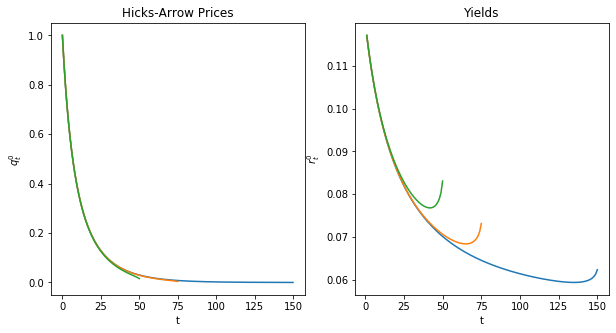

In [23]:
T_arr = [150, 75, 50]
plot_yield_curves(pp, 0, 0.3, k_ss/3, T_arr)

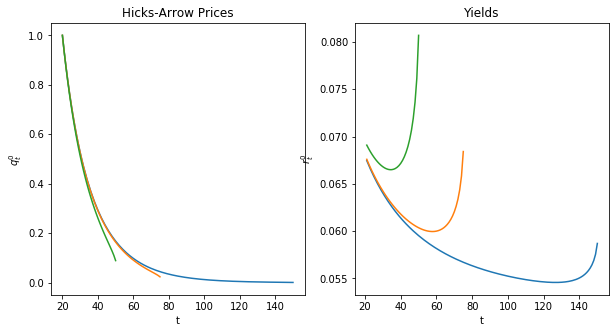

In [24]:
plot_yield_curves(pp, 20, 0.3, k_ss/3, T_arr)